In [1]:
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import torch
from tqdm import tqdm

/home/gusfilvi@GU.GU.SE/.conda/envs/AICS/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!nvidia-smi -L
#!CUDA_VISIBLE_DEVICES=MIG-00992b28-9de1-5e60-993b-b31261914ee9

GPU 0: NVIDIA GeForce GTX 1080 Ti (UUID: GPU-d349604b-7056-49bb-42cf-c9d6fefab40a)
GPU 1: NVIDIA GeForce GTX 1080 Ti (UUID: GPU-cb3041a3-8c48-0cbe-84ec-65646db1d19f)
GPU 2: NVIDIA GeForce GTX 1080 Ti (UUID: GPU-900b1eb3-d0c3-b27b-cec8-0c31c86bf0e9)
GPU 3: NVIDIA GeForce GTX 1080 Ti (UUID: GPU-1dbe66f4-c08c-4abe-14b9-af6c71af8407)


In [3]:
torch.cuda.is_available()

True

In [4]:
IRFL_images = load_dataset("lampent/IRFL", data_files='IRFL_images.zip')['train']

In [5]:
IRFL_metaphors_dataset = load_dataset("lampent/IRFL", 'metaphors-dataset')['dataset']
pd.DataFrame(IRFL_metaphors_dataset).head()

,phrase,figurative_type,source,uuid,category,theme
0,a lion on the battlefield,metaphor,https://www.israelhayom.com/2022/03/01/ukraini...,1009925977381951166573538219201192200312184397...,Figurative,NaN
1,a lion on the battlefield,metaphor,https://www.army.mil/article/260659/soldier_fo...,1110158887118147260462183682336548897929003447...,Figurative,NaN
2,a lion on the battlefield,metaphor,https://www.spokesman.com/stories/2012/aug/03/...,1150022408148171978092024654350648179128902573...,Figurative,NaN
3,a lion on the battlefield,metaphor,https://www.theguardian.com/books/2016/feb/26/...,4334616426942719694991676075800911426738633635...,Figurative,NaN
4,a lion on the battlefield,metaphor,https://www.polygon.com/22396791/battlefield-6...,6641158141547602068103775945956449252322278422...,Figurative,NaN


In [6]:
# Use this function for local run
def get_image_path_from_folder(image_name):
  image_folder_path = r'C:\devel\IRLM\assets\D_images'
  return f'{image_folder_path}\\{image_name.split(".")[0] + ".jpeg"}'

def get_image_path_from_hugginface_cache(image_name):
    chached_image_path = IRFL_images[0]['image'].filename
    chached_image_name = chached_image_path.split('/')[-1]
    return chached_image_path.replace(chached_image_name, str(image_name).split('.')[0] + '.jpeg')

def get_image(image_name):
  image_path = get_image_path_from_hugginface_cache(image_name)
  return Image.open(image_path)

# Preference task
IRFL_idiom_retrieval_task = load_dataset("lampent/IRFL", 'idiom-retrieval-task')["test"]
IRFL_metaphor_retrieval_task = load_dataset("lampent/IRFL", 'metaphor-retrieval-task')["test"]
IRFL_simile_retrieval_task = load_dataset("lampent/IRFL", 'simile-retrieval-task')["test"]
IRFL_open_simile_retrieval_task = load_dataset("lampent/IRFL", 'open-simile-retrieval-task')["test"]

In [7]:
pd.DataFrame(IRFL_metaphor_retrieval_task).head()

,type,figurative_type,images_metadata,first_category,second_category,phrase
0,FvsPL,metaphor,"[{""source"": ""https://www.digitaltrends.com/gam...","[""10099259773819511665735382192011922003121843...","[""11078326901046011968447681574355317880314753...",a lion on the battlefield
1,FvsPL,metaphor,"[{""source"": ""https://www.dreamstime.com/photos...","[""10166014906044208703673588942775925697155165...","[""10472048254956553018220152788477942861449900...",a mighty lion
2,FvsPL,metaphor,"[{""source"": ""https://unsplash.com/s/photos/nig...","[""10238828137439183291164181490873662971856351...","[""10441871388007842228188677322605006948277838...",a night owl
3,FvsPL,metaphor,"[{""source"": ""https://solarsystem.nasa.gov/moon...","[""10225631305623393414613139653908189397782521...","[""10975358208463655666118304845299235749355170...",a shinning star
4,FvsPL,metaphor,"[{""source"": ""https://www.istockphoto.com/photo...","[""13412256301354044503872943123661426267175623...","[""11009120221646905702971515855412252245336570...",blanket of bullets


In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision

from transformers import BertTokenizer, VisualBertModel

import pandas as pd
import numpy
import ast, os

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

detector = torchvision.models.resnet50(pretrained=True)
detector = torch.nn.Sequential(*list(detector.children())[:-1])
detector.eval()

batch_size = 128
device = torch.device('cuda:1')

/home/gusfilvi@GU.GU.SE/.conda/envs/AICS/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gusfilvi@GU.GU.SE/.conda/envs/AICS/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
import ast 

def get_data(task_name):
    figurative_images = [ast.literal_eval(image_list) for image_list in task_name['first_category']]
    partial_literal_images = [ast.literal_eval(image_list) for image_list in task_name['second_category']]
    phrases = task_name['phrase']

    figurative_dictionary = []
    for idx, element in enumerate(figurative_images):
        for image in element:
            dictionary = {'phrase': phrases[idx], 'image': image, 'type': 'figurative'}
            figurative_dictionary.append(dictionary)
        
    for idx, element in enumerate(partial_literal_images):
        for image in element:
            dictionary = {'phrase': phrases[idx], 'image': image, 'type': 'partial literal'}
            figurative_dictionary.append(dictionary)
    
    return figurative_dictionary

metaphor_data = get_data(IRFL_metaphor_retrieval_task)
idiom_data = get_data(IRFL_idiom_retrieval_task)
simile_data = get_data(IRFL_simile_retrieval_task)

In [10]:
def create_data_table(dictionary_list, data_kind):
    column_names=["phrase", "image", "type"]
    
    df = pd.DataFrame(dictionary_list, columns=column_names)
    filepath =  'data/' + data_kind + '.csv'
    file = df.to_csv(filepath, index=False)

create_data_table(metaphor_data, "metaphor_data")
create_data_table(idiom_data, "idiom_data")
create_data_table(simile_data, "simile_data")


In [11]:
df = pd.read_csv('data/metaphor_data.csv')
df.head()

,phrase,image,type
0,a lion on the battlefield,1009925977381951166573538219201192200312184397...,figurative
1,a lion on the battlefield,1110158887118147260462183682336548897929003447...,figurative
2,a lion on the battlefield,1150022408148171978092024654350648179128902573...,figurative
3,a lion on the battlefield,4334616426942719694991676075800911426738633635...,figurative
4,a lion on the battlefield,6641158141547602068103775945956449252322278422...,figurative


In [12]:
def get_features(image):
    vis_embeddings = detector(image.unsqueeze(0))
    return vis_embeddings

class Multimodal_Dataset(Dataset):
    def __init__(self, data, tokenizer):
        data = pd.read_csv(data)
        self.phrases = data['phrase']
        self.images = data['image']
        self.labels = data['type']

        transform_list = [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]
        self.transform = transforms.Compose(transform_list)

    def __len__(self):
        return len(self.phrases)

    def __getitem__(self, idx):
        
        encodings = tokenizer.encode_plus(self.phrases[idx], add_special_tokens=True, max_length=12, padding='max_length', truncation=True, return_tensors='pt')

        image = self.images[idx]

        label = 0 if self.labels[idx] == 'figurative' else 1

        img = get_image(image)
        img = img.convert('RGB')
        img = self.transform(img)
        
        embeddings = get_features(img)

        item = {'phrase': self.phrases[idx], 'input_ids': encodings['input_ids'], 'attn_mask': encodings['attention_mask'], 'token_type_ids': encodings['token_type_ids'], 'visual_embeddings': embeddings, 'type': label}
        return item

In [13]:
dataset = Multimodal_Dataset('data/simile_data.csv', tokenizer)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for batch in dataloader:
    ids = batch['visual_embeddings']
    print(ids.size())
    break

torch.Size([128, 1, 2048, 1, 1])


In [14]:
class VISUAL_BERT(nn.Module):
    def __init__(self):
        super(VISUAL_BERT, self).__init__()
        self.visual_bert = VisualBertModel.from_pretrained("uclanlp/visualbert-vqa-coco-pre")
        self.classifier = nn.Linear(self.visual_bert.config.hidden_size, 2)

    def forward(self, input_ids, attn_masks, token_type_ids, visual_embeddings):
        
        visual_token_type_ids = torch.ones(visual_embeddings.shape[:-1], dtype=torch.long).to(device)
        visual_attention_mask = torch.ones(visual_embeddings.shape[:-1], dtype=torch.float).to(device)
        
        outputs = self.visual_bert(input_ids=input_ids, attention_mask=attn_masks, token_type_ids=token_type_ids, visual_embeds=visual_embeddings, visual_attention_mask=visual_attention_mask, visual_token_type_ids=visual_token_type_ids)
        predictions = self.classifier(outputs.last_hidden_state[:, 0, :])

        return predictions

In [15]:
model = VISUAL_BERT().to(device)
model.eval()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

total_loss = 0
predictions_visual = []
gold_labels_visual = []
losses = []

with torch.no_grad():
    for batch in tqdm(dataloader):
        input_ids = torch.Tensor(batch['input_ids']).long().to(device)
        
        attn_masks = torch.Tensor(batch['attn_mask']).float().to(device)
        token_type_ids = torch.Tensor(batch['token_type_ids']).long().to(device)
        
        visual_embeddings = torch.Tensor(batch['visual_embeddings']).float().to(device)
        visual_embeddings = visual_embeddings.squeeze(3)
        visual_embeddings = visual_embeddings.squeeze(3).to(device)
        # print(input_ids.squeeze().size())
        # print(visual_embeddings.size())
        # print(attn_masks.size())
        # print(token_type_ids.size())
        gold_label = batch['type'].to(device)

        outputs = model(input_ids.squeeze(1), attn_masks.squeeze(1), token_type_ids.squeeze(1), visual_embeddings)

        gold_labels_visual.extend(gold_label.cpu().numpy())
        
        loss = loss_fn(outputs, gold_label)
        losses.append(loss)
        total_loss += loss.item()

        _, predicted_labels = torch.max(outputs, dim=1)
        
        predictions_visual.extend(predicted_labels.cpu().numpy())

average_loss = total_loss / len(dataloader)
print(f'Average Loss: {average_loss}')

100%|██████████| 35/35 [05:28<00:00,  9.39s/it]

Average Loss: 0.8294984085219247


In [16]:
from sklearn.metrics import classification_report

report = classification_report(gold_labels_visual, predictions_visual)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.25      1.00      0.40      1107
           1       0.00      0.00      0.00      3314

    accuracy                           0.25      4421
   macro avg       0.13      0.50      0.20      4421
weighted avg       0.06      0.25      0.10      4421



/home/gusfilvi@GU.GU.SE/.conda/envs/AICS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gusfilvi@GU.GU.SE/.conda/envs/AICS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gusfilvi@GU.GU.SE/.conda/envs/AICS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [28]:
def split_dataset(csv_file):
    
    file = pd.read_csv(csv_file)
    
    print("total words:",len(file))
    randomized_data = file.sample(frac=1, random_state=42)
    print("total randomized words:",len(randomized_data))

    train = int(len(randomized_data) * 0.8)

    train_data = randomized_data[:train]
    print("total training set:",len(train_data))

    test_data = randomized_data[train:]
    print("total testing set:",len(test_data))

    train_filepath = "data/train_dataset.csv"
    test_filepath = "data/test_dataset.csv"
    train_data.to_csv(train_filepath, index=False)
    test_data.to_csv(test_filepath, index=False)

split_dataset('data/balanced_dataset.csv')

total words: 2214
total randomized words: 2214
total training set: 1771
total testing set: 443


In [29]:
train_data = Multimodal_Dataset('data/train_dataset.csv', tokenizer=tokenizer)
test_data = Multimodal_Dataset('data/test_dataset.csv', tokenizer=tokenizer)

In [19]:
def count_instances(csv_path):
    df = pd.read_csv(csv_path)
    figurative = 0
    partial_literal = 0
    for label in df['type'].to_list():
        if label == 'figurative':
            figurative += 1
        else:
            partial_literal += 1

    print(' Number of figurative instances:', figurative, '\n','Number of partial literal instances:', partial_literal)

In [30]:
count_instances('data/train_dataset.csv')

 Number of figurative instances: 894 
 Number of partial literal instances: 877


In [26]:
def balance_data(csv_file):
    df = pd.read_csv(csv_file)
    figurative = df.head(1107)
    literal = df.tail(1107)
    balanced_dataset = pd.concat([figurative, literal])
    balanced_dataset.to_csv('data/balanced_dataset.csv', index=False)

balance_data('data/simile_data.csv')

In [31]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [32]:
language_and_vision_model = VISUAL_BERT().to(device)
epochs = 2

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(language_and_vision_model.parameters(), lr=0.001)

language_and_vision_model.train()

losses_train = []
    
for epoch in range(epochs):
    total_loss = 0
    for i, batch in enumerate(train_dataloader):
        input_ids = torch.LongTensor(batch['input_ids']).to(device)
        attn_masks = torch.Tensor(batch['attn_mask']).float().to(device)
        #print(type(attn_masks))
        token_type_ids = torch.LongTensor(batch['token_type_ids']).to(device)
        
        visual_embeddings = torch.FloatTensor(batch['visual_embeddings']).to(device)
        
        visual_embeddings = visual_embeddings.squeeze(3)
        visual_embeddings = visual_embeddings.squeeze(3)
        
        gold_label = batch['type'].to(device)
    
        outputs = language_and_vision_model(input_ids.squeeze(), attn_masks.squeeze(), token_type_ids.squeeze(), visual_embeddings)

        loss = loss_fn(outputs, gold_label)
        losses_train.append(loss.detach().cpu().numpy())
        total_loss += loss.item()

        print("epoch:",epoch, "loss:", total_loss/(i+1), end='\r')

        loss.backward()

        optimizer.step()

        optimizer.zero_grad()

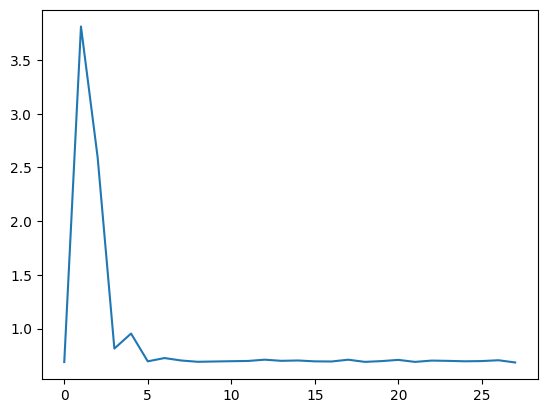

In [33]:
plt.plot(losses_train)

In [34]:
language_and_vision_model.eval()

gold_labels = []
predictions = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = torch.LongTensor(batch['input_ids']).to(device)
        attn_masks = torch.Tensor(batch['attn_mask']).float().to(device)
        token_type_ids = torch.LongTensor(batch['token_type_ids']).to(device)
        
        visual_embeddings = torch.FloatTensor(batch['visual_embeddings']).to(device)
        visual_embeddings = visual_embeddings.squeeze(3)
        visual_embeddings = visual_embeddings.squeeze(3)
        # print(input_ids.size())
        # print(visual_embeddings.size())
        # print(attn_masks.size())
        # print(token_type_ids.size())
        gold_label = batch['type'].to(device)

        outputs = language_and_vision_model(input_ids.squeeze(), attn_masks.squeeze(), token_type_ids.squeeze(), visual_embeddings)

        gold_labels.extend(gold_label.cpu().numpy())

        _, predicted_labels = torch.max(outputs, dim=1)
        
        predictions.extend(predicted_labels.cpu().numpy())

gold_labels = numpy.array(gold_labels)
predictions = numpy.array(predictions)

100%|██████████| 4/4 [00:40<00:00, 10.20s/it]


In [35]:
from sklearn.metrics import classification_report

report = classification_report(gold_labels, predictions)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       213
           1       0.52      1.00      0.68       230

    accuracy                           0.52       443
   macro avg       0.26      0.50      0.34       443
weighted avg       0.27      0.52      0.35       443



/home/gusfilvi@GU.GU.SE/.conda/envs/AICS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gusfilvi@GU.GU.SE/.conda/envs/AICS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gusfilvi@GU.GU.SE/.conda/envs/AICS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [37]:
food = load_dataset("food101", split="train[:5000]")

Generating validation split: 100%|██████████| 25250/25250 [05:21<00:00, 78.61 examples/s] 


In [38]:
food = food.train_test_split(test_size=0.2)

In [40]:
food["train"][1]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x511>,
 'label': 10}

In [41]:
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label